### 이미지 기본 정보 추출 (해상도, 채널)

train data set channel: 3
test data set channel: 3


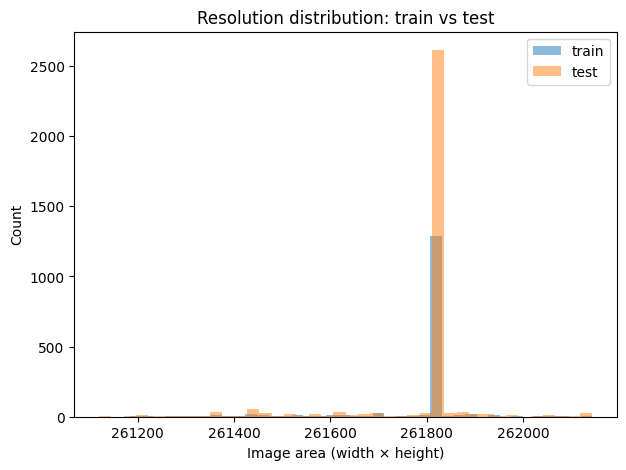

In [20]:
import os, cv2, pandas as pd
import matplotlib.pyplot as plt

def list_image_files(img_dir):
    exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'}
    files = [f for f in os.listdir(img_dir) if os.path.splitext(f)[1].lower() in exts]
    files.sort()
    return files

def load_image_rgb(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(path)
    if img.ndim == 2:  # grayscale
        return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    if img.shape[2] == 4:  # BGRA
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def get_basic_info(img_dir, max_images=None):
    rows = []
    names = list_image_files(img_dir)
    if max_images is not None:
        names = names[:max_images]
    for name in names:
        path = os.path.join(img_dir, name)
        img  = load_image_rgb(path)
        h, w = img.shape[:2]
        ch   = img.shape[2]
        rows.append({"filename": name, "width": w, "height": h, "channels": ch})
    return pd.DataFrame(rows)

def plot_area_hist(df_train, df_test, bins=40):
    area_train = df_train["width"] * df_train["height"]
    area_test  = df_test["width"] * df_test["height"]

    plt.figure(figsize=(7,5))
    plt.hist(area_train, bins=bins, alpha=0.5, label="train")
    plt.hist(area_test, bins=bins, alpha=0.5, label="test")
    plt.xlabel("Image area (width × height)")
    plt.ylabel("Count")
    plt.title("Resolution distribution: train vs test")
    plt.legend()
    plt.show()

train_dir = "../data/train"
test_dir  = "../data/test"

df_train_basic = get_basic_info(train_dir)
df_test_basic  = get_basic_info(test_dir)

print(f"train data set channel: {df_train_basic.channels.unique()[0]}")
print(f"test data set channel: {df_test_basic.channels.unique()[0]}")
plot_area_hist(df_train_basic, df_test_basic)

### 밝기/대비 및 블러 정보 추출

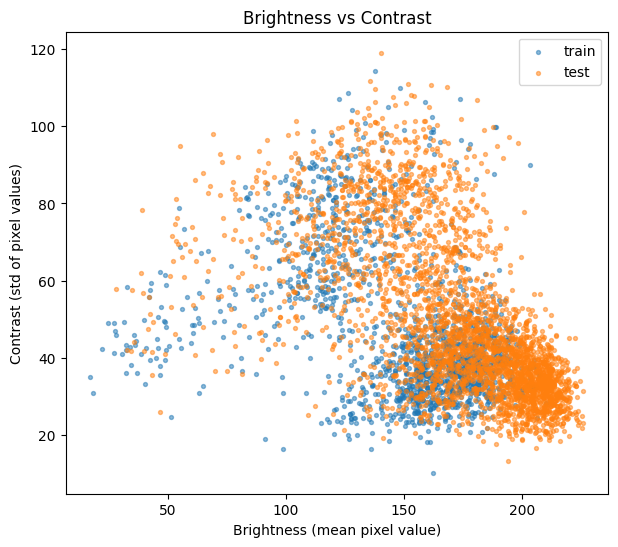

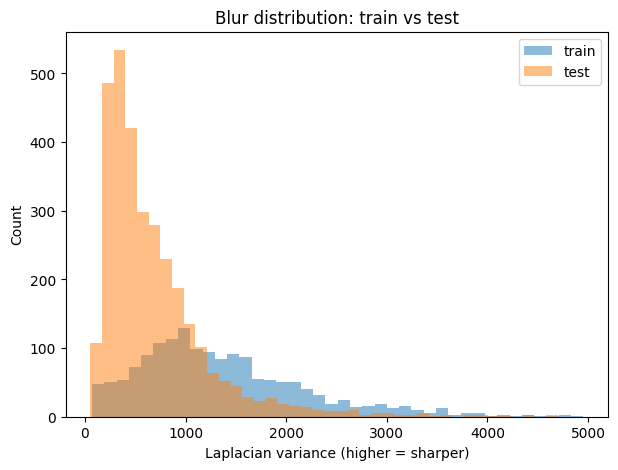

In [21]:
import numpy as np

def brightness_contrast(gray):
    return float(gray.mean()), float(gray.std())

def variance_of_laplacian(gray):
    return float(cv2.Laplacian(gray, cv2.CV_64F).var())

def get_quality_info(img_dir, max_images=None):
    rows = []
    names = list_image_files(img_dir)
    if max_images is not None:
        names = names[:max_images]
    for name in names:
        path = os.path.join(img_dir, name)
        img  = load_image_rgb(path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        b, c = brightness_contrast(gray)
        lap  = variance_of_laplacian(gray)
        rows.append({"filename": name, "brightness": b, "contrast": c, "lap_var": lap})
    return pd.DataFrame(rows)

def plot_brightness_contrast(df_train, df_test):
    plt.figure(figsize=(7,6))
    plt.scatter(df_train["brightness"], df_train["contrast"], s=8, alpha=0.5, label="train")
    plt.scatter(df_test["brightness"], df_test["contrast"], s=8, alpha=0.5, label="test")
    plt.xlabel("Brightness (mean pixel value)")
    plt.ylabel("Contrast (std of pixel values)")
    plt.title("Brightness vs Contrast")
    plt.legend()
    plt.show()

def plot_blur_hist(df_train, df_test, bins=40):
    plt.figure(figsize=(7,5))
    plt.hist(df_train["lap_var"], bins=bins, alpha=0.5, label="train")
    plt.hist(df_test["lap_var"], bins=bins, alpha=0.5, label="test")
    plt.xlabel("Laplacian variance (higher = sharper)")
    plt.ylabel("Count")
    plt.title("Blur distribution: train vs test")
    plt.legend()
    plt.show()

df_train_q = get_quality_info(train_dir)
df_test_q  = get_quality_info(test_dir)

df_train = df_train_basic.merge(df_train_q, on="filename")
df_test  = df_test_basic.merge(df_test_q,  on="filename")

plot_brightness_contrast(df_train, df_test)
plot_blur_hist(df_train, df_test)

### 회전/플립

In [43]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from pytesseract import Output

# --- 회전 각도(0/90/180/270) 추정: OSD 사용 ---
def ocr_rotation_deg(img_rgb):
    """
    Tesseract OSD(Orientation & Script Detection)로 회전 각도 추정.
    반환: 0, 90, 180, 270 중 하나 또는 None
    """
    try:
        osd = pytesseract.image_to_osd(img_rgb, output_type=Output.DICT)
        deg = osd.get("rotate", None)
        if deg is None:
            return None
        return int(deg)
    except Exception:
        return None

# --- OCR 신뢰도(평균 conf) 계산: 좌우 플립 판정에 사용 ---
def ocr_mean_confidence(img_rgb, lang="eng+kor"):
    """
    pytesseract.image_to_data로 단어 단위 conf를 받아 평균값 반환.
    텍스트가 거의 없으면 낮게 나오거나 -1이 섞일 수 있어 필터링.
    """
    try:
        data = pytesseract.image_to_data(img_rgb, lang=lang, output_type=Output.DICT)
        confs = [int(c) for c in data["conf"] if c not in (-1, "-1")]
        if len(confs) == 0:
            return 0.0
        return float(np.mean(confs))
    except Exception:
        return 0.0

def detect_hflip_by_ocr(img_rgb, lang="eng+kor", delta=10.0):
    """
    좌우 플립 여부 추정(휴리스틱):
      - 원본과 좌우 플립한 이미지의 OCR 평균 conf 비교
      - 플립 쪽 conf가 delta 이상 높으면 '뒤집혀 있었다'고 판단
    반환: True(좌우 플립으로 추정) / False
    주의: 텍스트가 희박하거나 비문서 이미지면 정확도 떨어질 수 있음.
    """
    conf_orig = ocr_mean_confidence(img_rgb, lang=lang)
    hflip_img = cv2.flip(img_rgb, 1)
    conf_flip = ocr_mean_confidence(hflip_img, lang=lang)
    return (conf_flip - conf_orig) >= delta, conf_orig, conf_flip

def add_ocr_rotation_and_hflip(df, img_dir, lang="eng+kor", sample_n=None, seed=0, delta=10.0):
    """
    df에 'ocr_deg'와 'hflip_flag' 두 컬럼 추가.
    - sample_n 지정 시 무작위 샘플만 빠르게 분석(속도 개선용)
    - delta: 좌우 플립 판정 임계치(기본 10)
    """
    rng = np.random.default_rng(seed)
    df2 = df.copy()

    if sample_n is not None and sample_n < len(df2):
        df2 = df2.sample(sample_n, random_state=seed).reset_index(drop=True)

    ocr_degs = []
    hflips   = []

    for name in df2["filename"]:
        path = os.path.join(img_dir, name)
        img  = cv2.imread(path)
        img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        deg = ocr_rotation_deg(img)
        ocr_degs.append(deg)

        # 좌우 플립 판정 (delta 기준)
        is_hflip, conf_o, conf_f = detect_hflip_by_ocr(img, lang=lang, delta=delta)
        hflips.append(is_hflip)

    df2["ocr_deg"]    = ocr_degs        # 0 / 90 / 180 / 270 / None
    df2["hflip_flag"] = hflips          # True / False (휴리스틱)

    return df2

In [44]:
df_train_o = add_ocr_rotation_and_hflip(df_train, train_dir, lang="eng+kor", sample_n=None, delta=10.0)
df_test_o  = add_ocr_rotation_and_hflip(df_test,  test_dir,  lang="eng+kor", sample_n=None, delta=10.0)

df_train_o[["filename","ocr_deg","hflip_flag"]].head()
df_test_o[["filename","ocr_deg","hflip_flag"]].head()

,filename,ocr_deg,hflip_flag
0,0008fdb22ddce0ce.jpg,NaN,False
1,00091bffdffd83de.jpg,NaN,False
2,00396fbc1f6cc21d.jpg,NaN,False
3,00471f8038d9c4b6.jpg,NaN,False
4,00901f504008d884.jpg,NaN,False


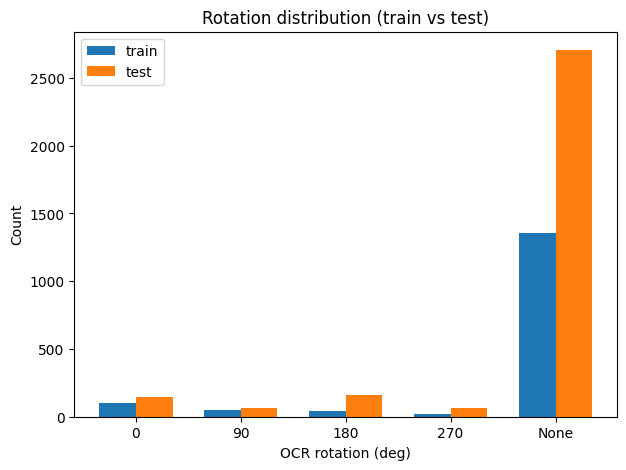

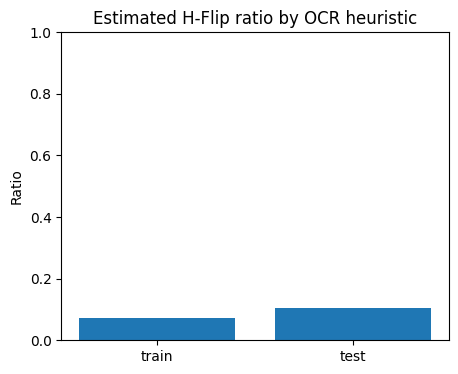

In [45]:
def plot_rotation_bar(df_train_o, df_test_o):
    # 회전 각도 빈도
    rot_labels = [0, 90, 180, 270, None]
    ct_train = df_train_o["ocr_deg"].value_counts(dropna=False).to_dict()
    ct_test  = df_test_o["ocr_deg"].value_counts(dropna=False).to_dict()

    # None 키 통일
    ct_train = { (k if k in rot_labels else None): v for k, v in ct_train.items() }
    ct_test  = { (k if k in rot_labels else None): v for k, v in ct_test.items()  }

    xs = np.arange(len(rot_labels))
    w  = 0.35

    plt.figure(figsize=(7,5))
    plt.bar(xs - w/2, [ct_train.get(k,0) for k in rot_labels], width=w, label="train")
    plt.bar(xs + w/2, [ct_test.get(k,0)  for k in rot_labels], width=w, label="test")
    plt.xticks(xs, [str(k) for k in rot_labels])
    plt.xlabel("OCR rotation (deg)")
    plt.ylabel("Count")
    plt.title("Rotation distribution (train vs test)")
    plt.legend()
    plt.show()

def plot_hflip_ratio(df_train_o, df_test_o):
    # 좌우 플립 추정 비율
    r_train = float(df_train_o["hflip_flag"].mean())
    r_test  = float(df_test_o["hflip_flag"].mean())

    plt.figure(figsize=(5,4))
    plt.bar(["train","test"], [r_train, r_test])
    plt.ylim(0, 1)
    plt.ylabel("Ratio")
    plt.title("Estimated H-Flip ratio by OCR heuristic")
    plt.show()


plot_rotation_bar(df_train_o, df_test_o)
plot_hflip_ratio(df_train_o, df_test_o)

### 랜덤한 25개의 test data image 출력

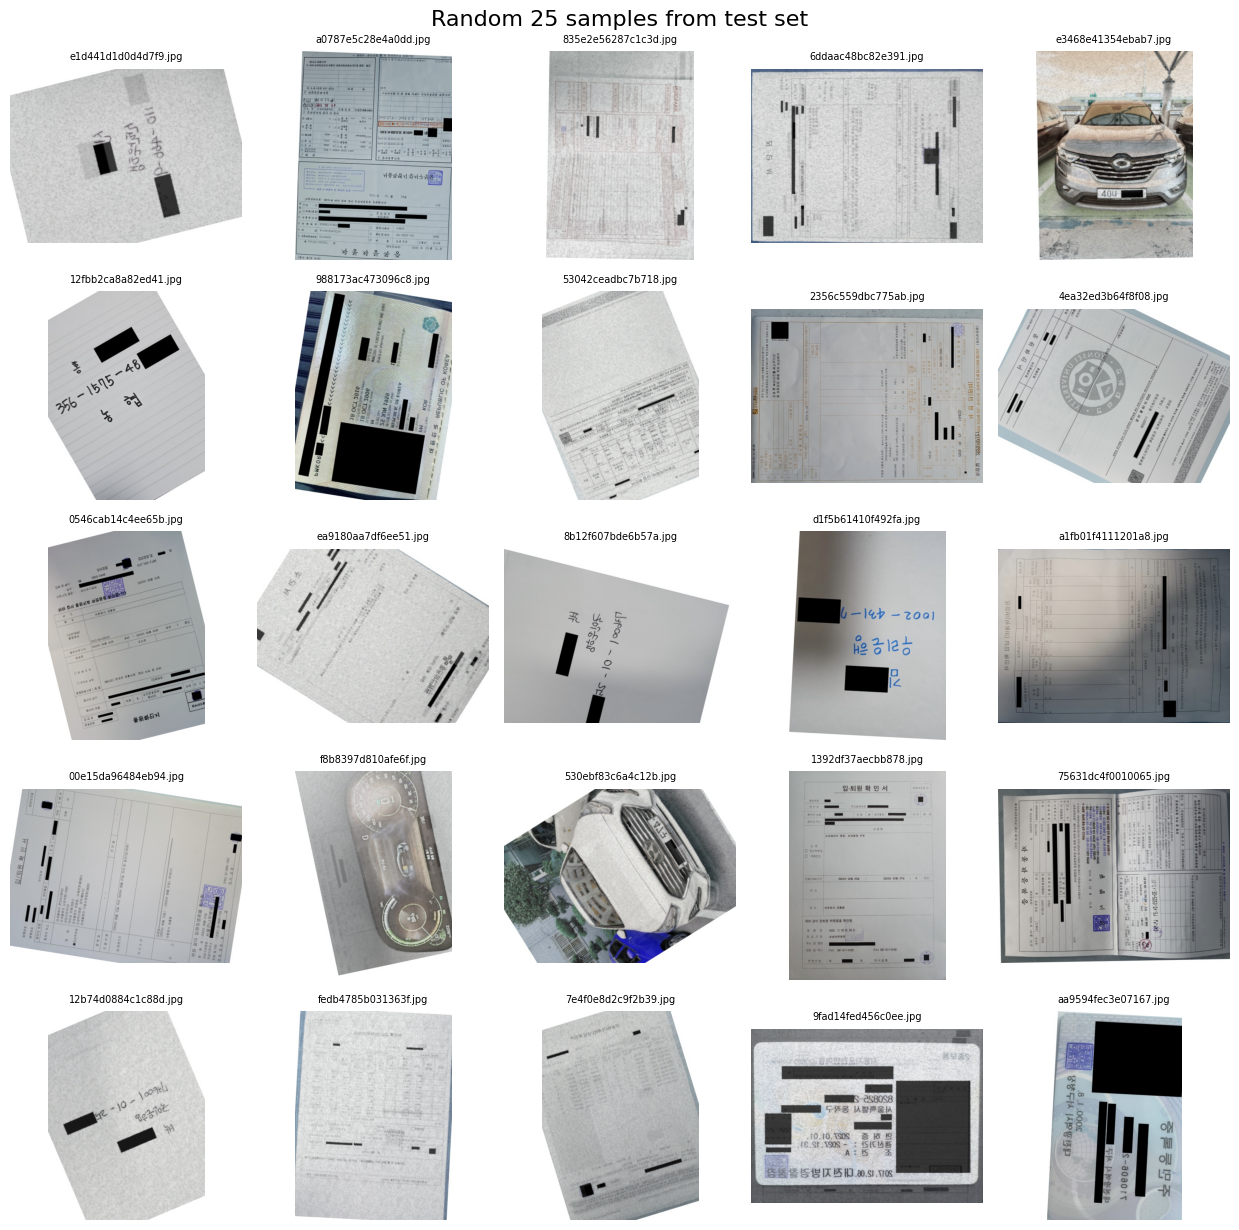

In [47]:
import os
import random

import cv2
import matplotlib.pyplot as plt

def plot_random_images(img_dir, n=25, seed=42):
    random.seed(seed)
    files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'))]
    sample = random.sample(files, n)

    rows = cols = int(n**0.5)
    plt.figure(figsize=(cols*2.5, rows*2.5))
    for i, fname in enumerate(sample, 1):
        path = os.path.join(img_dir, fname)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.title(fname, fontsize=7)
        plt.axis('off')
    plt.suptitle(f"Random {n} samples from test set", fontsize=16)
    plt.tight_layout()
    plt.show()

TEST_IMG_DIR = '../data/test'
plot_random_images(TEST_IMG_DIR, n=25, seed=42)

### 요약

In [11]:
def compare_train_test(df_train, df_test):
    def desc(x): return x.describe().to_dict()
    comp = {
        "count": {"train": len(df_train), "test": len(df_test)},
        "area_desc": {
            "train": desc(df_train["width"]*df_train["height"]),
            "test":  desc(df_test["width"]*df_test["height"]),
        },
        "brightness_desc": {"train": desc(df_train["brightness"]), "test": desc(df_test["brightness"])},
        "contrast_desc":   {"train": desc(df_train["contrast"]),   "test": desc(df_test["contrast"])},
        "lap_var_desc":    {"train": desc(df_train["lap_var"]),    "test": desc(df_test["lap_var"])},
        "tilt_deg_desc":   {"train": desc(df_train["tilt_deg"].dropna()), "test": desc(df_test["tilt_deg"].dropna())},
        "channels_counts": {
            "train": df_train["channels"].value_counts().to_dict(),
            "test":  df_test["channels"].value_counts().to_dict(),
        }
    }
    return comp

comp = compare_train_test(df_train, df_test)
comp


{'count': {'train': 1570, 'test': 3140},
 'area_desc': {'train': {'count': 1570.0,
   'mean': 261779.94968152867,
   'std': 120.72665854479358,
   'min': 261184.0,
   '25%': 261813.0,
   '50%': 261813.0,
   '75%': 261813.0,
   'max': 262144.0},
  'test': {'count': 3140.0,
   'mean': 261787.03949044587,
   'std': 118.8356851753739,
   'min': 261120.0,
   '25%': 261813.0,
   '50%': 261813.0,
   '75%': 261813.0,
   'max': 262144.0}},
 'brightness_desc': {'train': {'count': 1570.0,
   'mean': 148.18873732842792,
   'std': 35.401049607430004,
   'min': 16.98916402164904,
   '25%': 126.74860848419954,
   '50%': 156.48684939250535,
   '75%': 174.0203504027684,
   'max': 210.39241748881835},
  'test': {'count': 3140.0,
   'mean': 172.18430678836057,
   'std': 34.593225457239775,
   'min': 27.87932226436426,
   '25%': 153.61148701554163,
   '50%': 177.73756268787264,
   '75%': 199.80841478459817,
   'max': 226.1730662724922}},
 'contrast_desc': {'train': {'count': 1570.0,
   'mean': 47.55603185